In [1]:
from langchain_core.messages import HumanMessage,SystemMessage
from langgraph.graph import StateGraph,START,END
from langchain_mistralai import ChatMistralAI
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict,Literal,Annotated
import operator
from pydantic import BaseModel,Field
load_dotenv()
import os

In [2]:
api_keys=[os.getenv('google'),os.getenv('mistral_ai')]

In [3]:
evaluator_llm=ChatMistralAI(api_key=api_keys[1])
genrator_llm=ChatGoogleGenerativeAI(api_key=api_keys[0],model='gemini-2.5-flash')
optimizer_llm=ChatMistralAI(api_key=api_keys[1],model_name='mistral-medium-2508')

In [4]:
class ContentGen(TypedDict):
    topic:str
    generated_content:str
    feedback:str
    evaluation_result:Literal['needs_improvement','not_satisfied','approved','can be better']
    optimized_result:str
    iteration:int
    max_iterations:int
    c_history:Annotated[list,operator.add]
    f_history:Annotated[list,operator.add]
    score:Annotated[list[int],operator.add]
    

In [5]:
class EVAL(BaseModel):
    feedback:str=Field(...,description='Detailed feedback on the basis of the essay')
    score:int=Field(description='Score out of 10',ge=0,le=10)
    eval_result:Literal['needs_improvement','not_satisfied','approved','can be better']=Field(...,description='eval_result should be based on the checks u put into the content generation process')

In [6]:
gen_with_structure=genrator_llm.with_structured_output(EVAL)

In [7]:
graph=StateGraph(ContentGen)

In [8]:
def generator(state:ContentGen)->ContentGen['generated_content']:
    topic=state['topic']
    prompt=[SystemMessage(content=" you are an expert and the smartest llm which can generate content for any topic with human like touch but professional like output"),HumanMessage(content=f"generate content for {topic} with human like touch but professional like output \n RULES ARE 1. use a professional tone 2. use a professional language 3. use a professional style 4. make sure to make it eye catching and retention rate should be high 5 max 200 words 6 there should be strong hooks everywhere so the person has to read the whole content this is the version {state['iteration']+1}")]
    generated_content=genrator_llm.invoke(prompt).content
    return {'generated_content':generated_content,'iteration':state['iteration'],'c_history':[generated_content]}

def evaluator(state:ContentGen)->ContentGen['evaluation_result']: 
    content=state['generated_content']
    message=[SystemMessage(content=" you are an expert and the smartest llm which can evaluate the content generated by the other llm and give feedback on the basis of the essay"),HumanMessage(content=f"evaluate the content generated by the other llm and give feedback on the basis of the essay \n content is {content}")]
    response=gen_with_structure.invoke(message)
    return {'evaluation_result':response.eval_result,'feedback':response.feedback,'score':[response.score],'f_history':[response.feedback]}

def optimizer(state:ContentGen)->ContentGen['optimized_result']:
    prompted=[SystemMessage(content=" you are an expert and the smartest llm which can optimize the content generated by the other llm and give feedback on the basis of the essay"),HumanMessage(content=f"optimize the content generated by the other llm on the topic {state['topic']}and give feedback on the basis of the essay \n content is {state['generated_content']}")]
    response=optimizer_llm.invoke(prompted).content
    iteration=state['iteration']+1
    return {'optimized_result':response,'iteration':iteration,'c_history':[response]}

In [16]:
def route_eval(state:ContentGen):
    if state['evaluation_result']=='needs_improvement' or state['evaluation_result']=='can be better' or state['evaluation_result']=='not_satisfied' :
        return 'needs_improvement'
    elif state['iteration']>=state['max_iterations']:
        return 'approved'
    elif state['score'][-1] > 8:  
        return 'needs_improvement'
    elif state['score'][-1]== 9:
        return 'approved'
    else:
        return 'approved'

In [10]:
def check_language(state:ContentGen)->ContentGen['optimized_result']:
    content=state['optimized_result']
    msg=[SystemMessage(content=" you are an expert and the smartest llm which can evaluate the content generated by the other llm and give feedback on the basis of the essay"),HumanMessage(content=f"if the language is too complex or very sophisticated make it simpler so any novice person can understand it  in this optimized content {content}")]
    response=optimizer_llm.invoke(msg).content
    return {'optimized_result':response}

In [ ]:
graph.add_node('generate',generator)
graph.add_node('evaluate',evaluator)
graph.add_node('optimize',optimizer)
graph.add_node('check_language',check_language)

graph.add_edge(START,'generate')
graph.add_edge('generate','evaluate')
graph.add_conditional_edges('evaluate',route_eval,{'approved':END,'needs_improvement':'optimize'})
graph.add_edge('optimize','check_language')
graph.add_edge('check_language','evaluate')

workflow=graph.compile()



In [12]:
def should_optimize(state:ContentGen):
    if state['iteration'] >= state['max_iterations']:
        return 'approved'
    return 'needs_improvement'

graph.add_conditional_edges('evaluate',should_optimize,{
    'approved':END,
    'needs_improvement':'optimize'
})

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


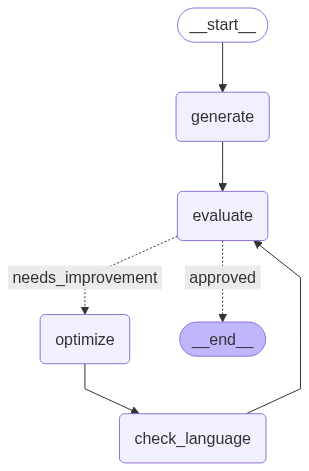

In [13]:
workflow

In [14]:
inital_state={'topic':'how to be a millionaire by 25 realistically from 0 and it should be working so tell me right now what to do','iteration':1,'max_iterations':4}
result=workflow.invoke(inital_state)

In [15]:
result

{'topic': 'how to be a millionaire by 25 realistically from 0 and it should be working so tell me right now what to do',
 'generated_content': "**Millionaire by 25? Dismiss the skepticism.** It’s not a fantasy; it’s a strategic blueprint demanding immediate action. Forget lottery tickets; this is about calculated execution.\n\n**Here's your roadmap, starting now:**\n\n1.  **Master a High-Income Skill:** Identify a skill in extreme demand – coding, advanced digital marketing, high-ticket sales, or specialized consulting. Dedicate every waking hour to becoming indispensable. **This is your primary wealth engine.**\n2.  **Radical Frugality & Aggressive Investing:** Live far below your means. Every dollar saved is a step closer; every investment is a seed planted. Prioritize high-growth assets. **Compound interest is your silent partner.**\n3.  **Create Value, Scale Impact:** Leverage your expertise into a scalable venture or command top-tier compensation. This isn't about luck; it's about